In [1]:
import pandas as pd
import matplotlib.pyplot as plt

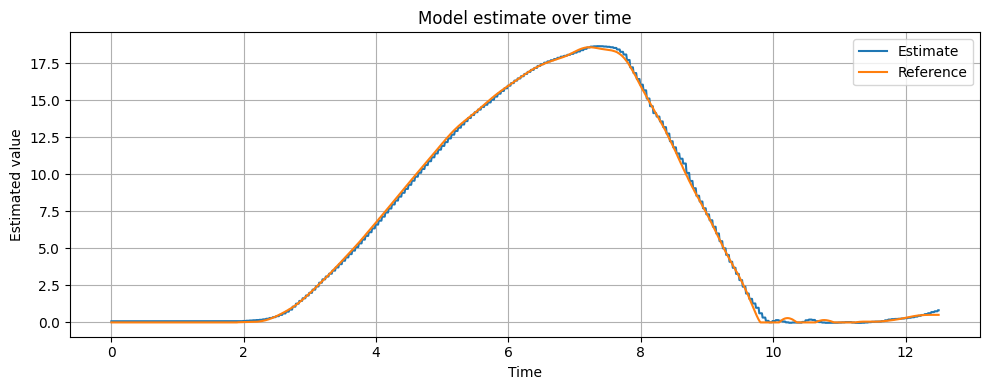

In [15]:
results_path = "../2_trained_models/LSTM/trained_models/i7/it_3_norm/results/lon/i7_43_norm.csv"
model_name = "model_LSTM_lon_32.pt"

df = pd.read_csv(results_path)

plt.figure(figsize=(10, 4))
plt.plot(df['time'], df[model_name], label='Estimate')
plt.plot(df['time'], df['veh_u'], label='Reference')
plt.xlabel('Time')
plt.ylabel('Estimated value')
plt.title('Model estimate over time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()